In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from json import loads, dumps



In [2]:
def parse_feature_importance(dataframe):

    result = dataframe['feature_importance'].fillna('{}')

    number_of_features = []
    features = []
    for i in result:
        j = i.replace("\'", "\"")
        js = loads(j)
        number_of_features.append(len(js.values()))
        features.append(list(js.keys()))

#     print(number_of_features)
    return number_of_features, features


def parse_join_path_features(dataframe):
    dataframe['join_path_features'] = dataframe['join_path_features'].fillna('')
    result = dataframe['join_path_features']

    number_of_features = []
    jp_features = []
    for i in result:
        j = i.replace("[", "")
        j = j.replace("]", "")
        j = j.replace("'", "")
        k = j.split(", ")
    #     print(k)
    #     print(len(k))

        if len(k) == 1:
            number_of_features.append(0)
        else:
            number_of_features.append(len(k))
        jp_features.append(k)

#     print(number_of_features)
    # print(jp_features)
    return number_of_features, jp_features




def determine_common_features(dataframe):

    nr_common_features = []
    difference = []

    for i, values in enumerate(features):
        set_a = set(values)
        set_b = set(jp_features[i])

#         print(set_a)
#         print(set_b)
    #     print(len(set_a.intersection(set_b)))

        nr_common_features.append(len(set_a.intersection(set_b)))
        difference.append(set_b - set_a)

    # print(nr_common_features)
    # print(difference)
    return nr_common_features, difference

# 1. Simple dataset

In [3]:

folder_name = os.path.abspath(os.path.abspath(''))

dataset_path = "results/simple"
tfd_filename = "results_tfd-top-15-id.csv"
arda_filename = "results_arda.csv"
mab_filename = "results_mab.csv"
base_filename = "results_base.csv"
all_filename = "results_unsplit.csv"


# Read data
df_tfd = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{tfd_filename}"), header=0)
df_arda = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{arda_filename}"), header=0)
df_mab = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{mab_filename}"), header=0)
df_base = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{base_filename}"), header=0)
df_all = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{all_filename}"), header=0)

# Create a big dataframe
dataframe = pd.concat([df_tfd, df_arda, df_mab, df_base])

# Remove unused columns
dataframe.drop(columns=['join_time', 'depth', 'redundancy_threshold'], inplace=True)


# Process columns
number_of_features, features = parse_feature_importance(dataframe)
dataframe['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(dataframe)
dataframe['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(dataframe)
dataframe['nr_common_features'] = nr_common_features
dataframe['different_features'] = difference

dataframe.loc[dataframe['approach']=='TFD_BFS', 'approach'] = 'AutoFeat'


# Get globnal variables 
algs = list(dataframe['algorithm'].unique())
print(algs)

tables = list(dataframe['data_label'].unique())
print(tables)

approach = list(dataframe['approach'].unique())
print(approach)





['LightGBM', 'RandomForest', 'ExtraTrees', 'XGBoost']
['credit', 'steel', 'jannis', 'miniboone', 'covertype', 'eyemove', 'bioresponse', 'school', 'air', 'yprop', 'superconduct']
['AutoFeat', 'ARDA', 'MAB', 'BASE']


ARDA: 0.6840598779640616
MAB: 0.6933701688952476
TFD: 0.7699859637173777


,approach,avg_acc,avg_feat_sel_time
0,ARDA,0.684060,123.125404
1,MAB,0.693370,321.109444
2,AutoFeat,0.769986,24.672999


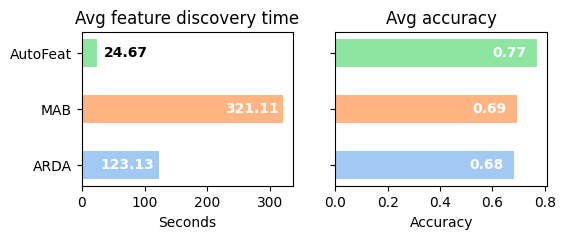

In [6]:
avgd_all = []

# a = dataframe.groupby(['approach', 'algorithm', 'data_label',])[['accuracy']].max().reset_index(level=['algorithm', 'data_label'])
a = dataframe.groupby(['approach', 'algorithm', 'data_label', 'feature_selection_time'])[['accuracy']].max().reset_index(level=['algorithm', 'data_label', 'feature_selection_time'])



ARDA = a.loc['ARDA']
ARDA = ARDA[~ARDA['data_label'].isin(['superconduct', 'yprop'])]

print(f"ARDA: {ARDA['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'ARDA'
avgd['avg_acc'] = ARDA['accuracy'].mean()
avgd['avg_feat_sel_time'] = ARDA['feature_selection_time'].mean()
avgd_all.append(avgd)


# BASE = a.loc['BASE']
# BASE = BASE[~BASE['data_label'].isin(['superconduct', 'yprop'])]
# print(f"BASE: {BASE['accuracy'].mean()}")

# avgd['approach'] = 'BASE'
# avgd['avg_acc'] = BASE['accuracy'].mean()


MAB = a.loc['MAB']
MAB = MAB[~MAB['data_label'].isin(['superconduct', 'yprop'])]
print(f"MAB: {MAB['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'MAB'
avgd['avg_acc'] = MAB['accuracy'].mean()
avgd['avg_feat_sel_time'] = MAB['feature_selection_time'].mean()
avgd_all.append(avgd)


TFD_BFS = a.loc['AutoFeat']
TFD_BFS = TFD_BFS[~TFD_BFS['data_label'].isin(['superconduct', 'yprop'])]
print(f"TFD: {TFD_BFS['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'AutoFeat'
avgd['avg_acc'] = TFD_BFS['accuracy'].mean()
avgd['avg_feat_sel_time'] = TFD_BFS['feature_selection_time'].mean()
avgd_all.append(avgd)


avgdf = pd.DataFrame(avgd_all)

display(avgdf)


pal = sns.color_palette("pastel")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), sharey=True)

rects1 = ax1.barh(avgdf['approach'], avgdf['avg_feat_sel_time'], align='center', height=0.5, 
                  color=[pal[0], pal[1], pal[2]], 
                  )

rects2 = ax2.barh(avgdf['approach'], avgdf['avg_acc'], align='center', height=0.5,
                 color=[pal[0], pal[1], pal[2]],)

large_percentiles = [round(p, 2) if p > 50 else '' for p in avgdf['avg_feat_sel_time']]
small_percentiles = [round(p, 2) if p <= 50 else '' for p in avgdf['avg_feat_sel_time']]
ax1.bar_label(rects1, small_percentiles,
              padding=5, color='black', fontweight='bold')
ax1.bar_label(rects1, large_percentiles,
              padding=-42, color='white', fontweight='bold')


small_percentiles = [round(p, 2) for p in avgdf['avg_acc']]
ax2.bar_label(rects2, small_percentiles,
              padding=-32, color='white', fontweight='bold')


ax1.set_xlabel('Seconds')
ax2.set_xlabel('Accuracy')

ax1.set_title('Avg feature discovery time')
ax2.set_title('Avg accuracy')

plt.savefig('plots/2024/simple_crown.pdf', dpi=300, bbox_inches="tight")



## Classification

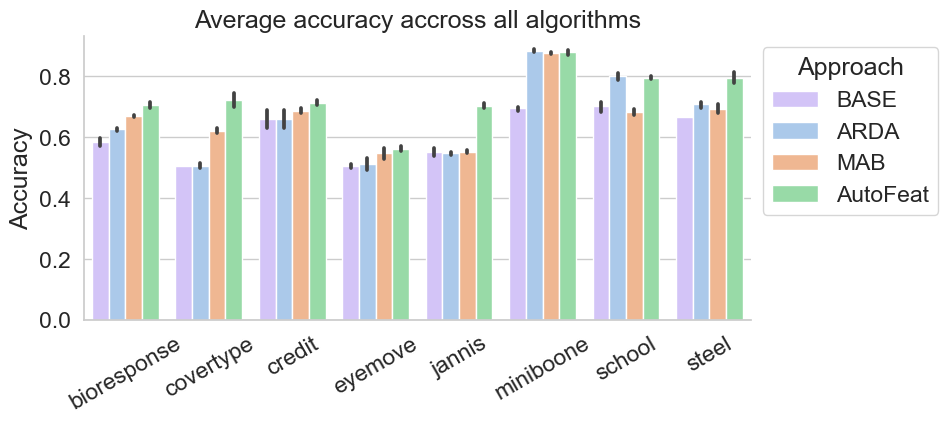

In [81]:
# Get accuracy
accuracy_cls = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()


sns.set(font_scale=1.5, style="whitegrid")
pal = sns.color_palette("pastel")

# plt.subplots(figsize=(20, 4))

aux = accuracy_cls[~accuracy_cls['data_label'].isin(['air', 'superconduct', 'yprop'])]
# aux = aux[~aux['approach'].isin(['MAB', 'BASE'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", 
                data=aux, kind="bar", height=4, aspect=2, 
                palette=[pal[4], pal[0], pal[1], pal[2]], hue_order=['BASE', 'ARDA', 'MAB', 'AutoFeat'])

# g.set_titles("{col_name} accuracy")
g.set_xlabels('')
g.set_ylabels('Accuracy')
plt.title("Average accuracy accross all algorithms")

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()
plt.legend(hh, ll, bbox_to_anchor=(1, 1), ncol=1, title="Approach")
# 
g.savefig('plots/2024/simple_accuracy_classification_top-15-id.png', dpi=300, bbox_inches="tight")


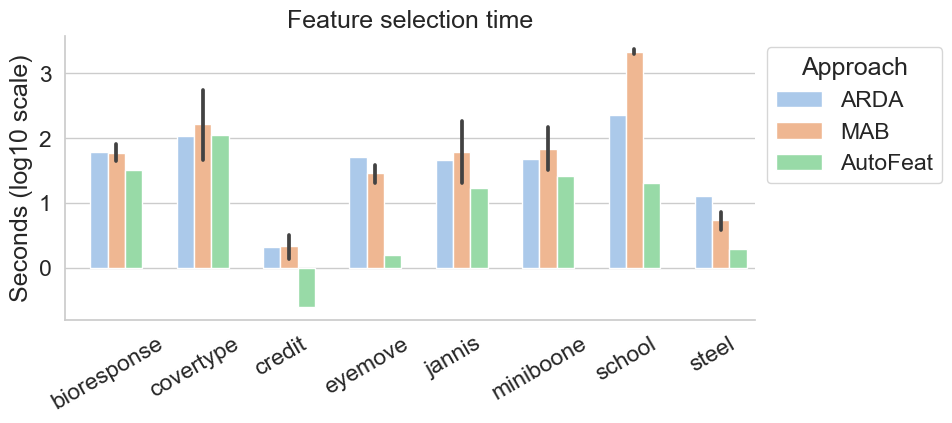

In [98]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

# Get total time
total_time = dataframe.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()
total_time['feature_selection_time'] = total_time['feature_selection_time'].apply(np.log10)

taux = total_time[~total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]
taux = taux[~taux['approach'].isin(['BASE'])]


g = sns.catplot(x="data_label", y="feature_selection_time", hue="approach", 
                data=taux, kind="bar", height=4, aspect=2, 
                palette=[pal[4], pal[0], pal[1], pal[2]], hue_order=['BASE', 'ARDA', 'MAB', 'AutoFeat'])

plt.title("Feature selection time")
g.set_xlabels('')
g.set_ylabels('Seconds (log10 scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh[1:], ll[1:], bbox_to_anchor=(1, 1), ncol=1, title="Approach")

g.savefig('plots/2024/simple_feature_selection_time_classification_top-15-id.png', dpi=300, bbox_inches="tight")


## Regression

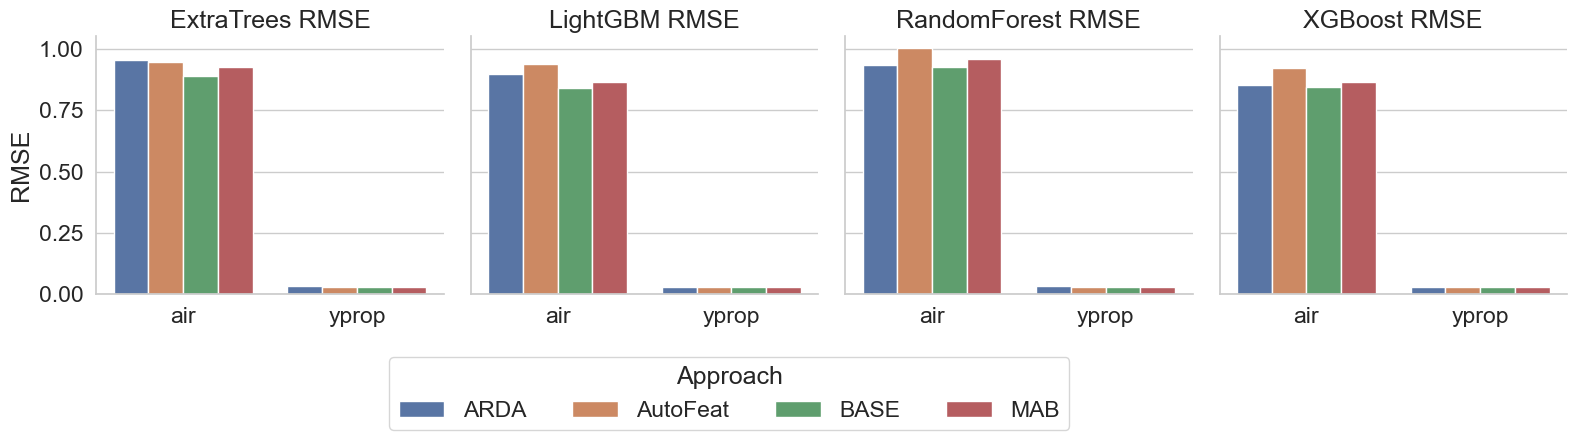

In [101]:
# Get accuracy
accuracy_reg = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].min().reset_index()

sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy_reg[accuracy_reg['data_label'].isin(['yprop', 'air'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} RMSE")
g.set_xlabels('')
g.set_ylabels('RMSE')
# plt.yticks([0,0.5, 3, 5, 8, 10, 13])


loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_2_regression_optimised_3.png', dpi=300, bbox_inches="tight")


In [ ]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

taux = total_time[total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=taux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} total_time")
g.set_xlabels('')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")

g.savefig('plots/2024/total_time_3_regression.png', dpi=300, bbox_inches="tight")


# 2. Normalised dataset

In [7]:

folder_name = os.path.abspath(os.path.abspath(''))

dataset_path = "results/normalised"
tfd_filename = "results_tfd-top-15-id.csv"
arda_filename = "results_arda.csv"
mab_filename = "results_mab_normalized.csv"
base_filename = "results_base.csv"
all_filename = "results_unsplit.csv"


# Read data
df_tfd = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{tfd_filename}"), header=0)
df_arda = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{arda_filename}"), header=0)
df_mab = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{mab_filename}"), header=0)
df_base = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{base_filename}"), header=0)
df_all = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/{all_filename}"), header=0)

# Create a big dataframe
dataframe = pd.concat([df_tfd, df_arda, df_base, df_mab])

# Remove unused columns
dataframe.drop(columns=['join_time', 'depth', 'redundancy_threshold'], inplace=True)
dataframe.loc[dataframe['approach']=='TFD_BFS', 'approach'] = 'AutoFeat'


# Process columns
number_of_features, features = parse_feature_importance(dataframe)
dataframe['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(dataframe)
dataframe['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(dataframe)
dataframe['nr_common_features'] = nr_common_features
dataframe['different_features'] = difference


# Get globnal variables 
algs = list(dataframe['algorithm'].unique())
print(algs)

tables = list(dataframe['data_label'].unique())
print(tables)

approach = list(dataframe['approach'].unique())
print(approach)






['LightGBM', 'RandomForest', 'ExtraTrees', 'XGBoost']
['credit', 'steel', 'jannis', 'miniboone', 'covertype', 'eyemove', 'yprop', 'superconduct']
['AutoFeat', 'ARDA', 'BASE', 'MAB']


ARDA: 0.6599862539274494
MAB: 0.7645022187344458
TFD: 0.7386785918309055


,approach,avg_acc,avg_feat_sel_time
0,ARDA,0.659986,48.742278
1,MAB,0.764502,461.304167
2,AutoFeat,0.738679,50.074437


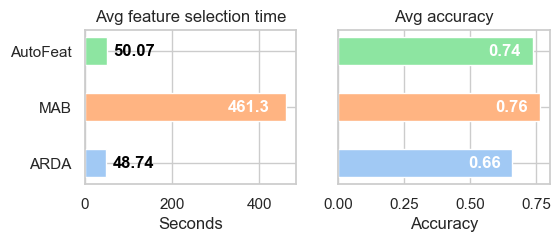

In [12]:
avgd_all = []

# a = dataframe.groupby(['approach', 'algorithm', 'data_label',])[['accuracy']].max().reset_index(level=['algorithm', 'data_label'])
a = dataframe.groupby(['approach', 'algorithm', 'data_label', 'feature_selection_time'])[['accuracy']].max().reset_index(level=['algorithm', 'data_label', 'feature_selection_time'])



ARDA = a.loc['ARDA']
ARDA = ARDA[~ARDA['data_label'].isin(['superconduct', 'yprop'])]

print(f"ARDA: {ARDA['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'ARDA'
avgd['avg_acc'] = ARDA['accuracy'].mean()
avgd['avg_feat_sel_time'] = ARDA['feature_selection_time'].mean()
avgd_all.append(avgd)


# BASE = a.loc['BASE']
# BASE = BASE[~BASE['data_label'].isin(['superconduct', 'yprop'])]
# print(f"BASE: {BASE['accuracy'].mean()}")

# avgd['approach'] = 'BASE'
# avgd['avg_acc'] = BASE['accuracy'].mean()


MAB = a.loc['MAB']
MAB = MAB[~MAB['data_label'].isin(['superconduct', 'yprop'])]
print(f"MAB: {MAB['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'MAB'
avgd['avg_acc'] = MAB['accuracy'].mean()
avgd['avg_feat_sel_time'] = MAB['feature_selection_time'].mean()
avgd_all.append(avgd)


TFD_BFS = a.loc['AutoFeat']
TFD_BFS = TFD_BFS[~TFD_BFS['data_label'].isin(['superconduct', 'yprop'])]
print(f"TFD: {TFD_BFS['accuracy'].mean()}")

avgd = {}
avgd['approach'] = 'AutoFeat'
avgd['avg_acc'] = TFD_BFS['accuracy'].mean()
avgd['avg_feat_sel_time'] = TFD_BFS['feature_selection_time'].mean()
avgd_all.append(avgd)


avgdf = pd.DataFrame(avgd_all)

display(avgdf)

sns.set(font_scale=1, style="whitegrid")
pal = sns.color_palette("pastel")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), sharey=True)

rects1 = ax1.barh(avgdf['approach'], avgdf['avg_feat_sel_time'], align='center', height=0.5, 
                  color=[pal[0], pal[1], pal[2]], 
                  )

rects2 = ax2.barh(avgdf['approach'], avgdf['avg_acc'], align='center', height=0.5,
                 color=[pal[0], pal[1], pal[2]],)

large_percentiles = [round(p, 2) if p > 100 else '' for p in avgdf['avg_feat_sel_time']]
small_percentiles = [round(p, 2) if p <= 100 else '' for p in avgdf['avg_feat_sel_time']]
ax1.bar_label(rects1, small_percentiles,
              padding=5, color='black', fontweight='bold')
ax1.bar_label(rects1, large_percentiles,
              padding=-42, color='white', fontweight='bold')


small_percentiles = [round(p, 2) for p in avgdf['avg_acc']]
ax2.bar_label(rects2, small_percentiles,
              padding=-32, color='white', fontweight='bold')


ax1.set_xlabel('Seconds')
ax2.set_xlabel('Accuracy')

ax1.set_title('Avg feature selection time')
ax2.set_title('Avg accuracy')

plt.savefig('plots/2024/normalised_crown.pdf', dpi=300, bbox_inches="tight")



## Classification

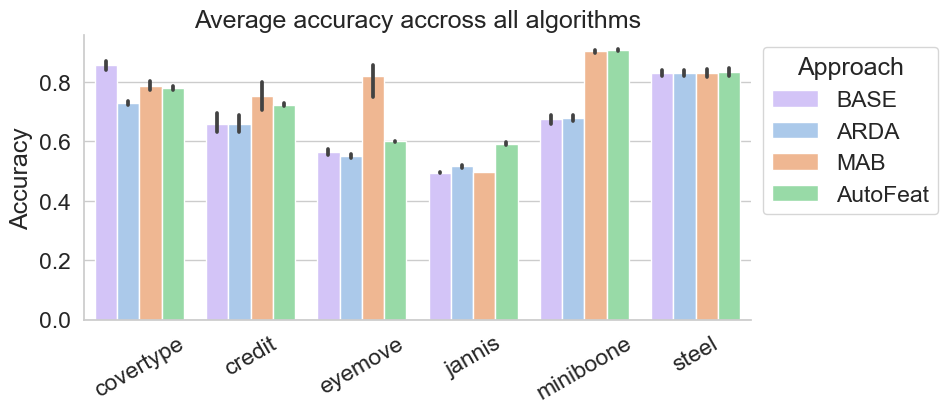

In [13]:
# Get accuracy
accuracy_cls = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()


sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy_cls[~accuracy_cls['data_label'].isin(['air', 'superconduct', 'yprop'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", 
                data=aux, kind="bar", height=4, aspect=2,
               palette=[pal[4], pal[0], pal[1], pal[2]], hue_order=['BASE', 'ARDA', 'MAB', 'AutoFeat'])

# g.set_titles("{col_name} accuracy")
g.set_xlabels('')
g.set_ylabels('Accuracy')
plt.title("Average accuracy accross all algorithms")

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()
plt.legend(hh, ll, bbox_to_anchor=(1, 1), ncol=1, title="Approach")
# 
g.savefig('plots/2024/normalised_accuracy_top-15-id.png', dpi=300, bbox_inches="tight")


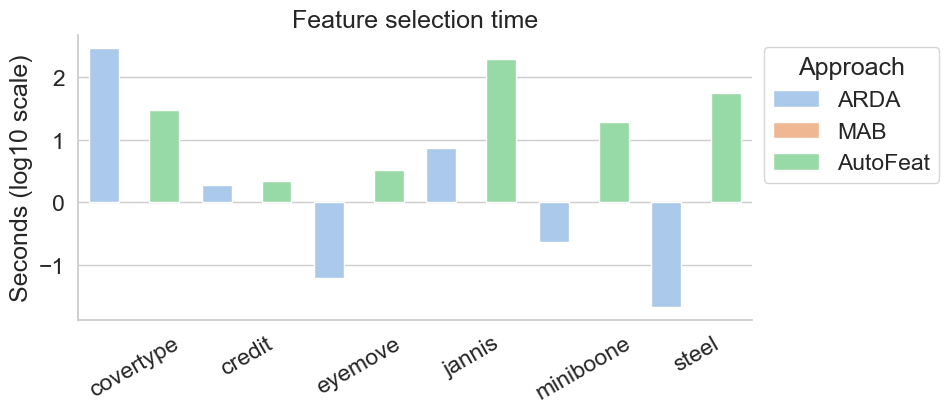

In [109]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

# Get total time
total_time = dataframe.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()
total_time['feature_selection_time'] = total_time['feature_selection_time'].apply(np.log10)

taux = total_time[~total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="feature_selection_time", hue="approach", 
                data=taux, kind="bar", height=4, aspect=2,
               palette=[pal[0], pal[1], pal[2]], hue_order=['ARDA', 'MAB', 'AutoFeat'])

plt.title("Feature selection time")
g.set_xlabels('')
g.set_ylabels('Seconds (log10 scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(1, 1), ncol=1, title="Approach")

g.savefig('plots/2024/normalised_feature_selection_time_top-15-id.png', dpi=300, bbox_inches="tight")


In [81]:
dataframe

,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,rank,number_features_importance,number_join_path_features,nr_common_features,different_features
0,LightGBM,credit/table9.csv--credit_amount-credit/table1...,TFD_BFS,credit,5.175580,2.116118,0.690000,3.059461,"{'credit/table14.csv.other_parties': 0.0, 'cre...","['credit/table14.csv.other_parties', 'credit/t...",0.65,1.489864,2,2,2,{}
1,RandomForest,credit/table9.csv--credit_amount-credit/table1...,TFD_BFS,credit,5.175580,2.116118,0.655000,3.059461,{'credit/table14.csv.duration': -0.00300000000...,"['credit/table14.csv.other_parties', 'credit/t...",0.65,1.489864,2,2,2,{}
2,ExtraTrees,credit/table9.csv--credit_amount-credit/table1...,TFD_BFS,credit,5.175580,2.116118,0.660000,3.059461,{'credit/table14.csv.duration': 0.002000000000...,"['credit/table14.csv.other_parties', 'credit/t...",0.65,1.489864,2,2,2,{}
3,XGBoost,credit/table9.csv--credit_amount-credit/table1...,TFD_BFS,credit,5.175580,2.116118,0.660000,3.059461,{'credit/table14.csv.duration': -0.00200000000...,"['credit/table14.csv.other_parties', 'credit/t...",0.65,1.489864,2,2,2,{}
4,LightGBM,credit/table9.csv--credit_amount-credit/table1...,TFD_BFS,credit,5.025602,2.116118,0.730000,2.909484,{'credit/table8.csv.duration': 0.0519999999999...,"['credit/table8.csv.savings_status', 'credit/t...",0.65,1.449248,3,3,3,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,XGBoost,yprop,BASE,yprop,0.000000,NaN,0.027577,NaN,"{'oz250': 0.0033252670446117945, 'oz249': 0.00...","['oz1', 'oz247', 'oz249', 'oz250', 'oz251', 'o...",NaN,NaN,8,8,8,{}
28,LightGBM,superconduct,BASE,superconduct,0.000000,NaN,20.641699,NaN,{'wtd_range_atomic_radius': 17.596463328332515...,"['wtd_mean_atomic_mass', 'wtd_range_atomic_rad...",NaN,NaN,2,2,2,{}
29,RandomForest,superconduct,BASE,superconduct,0.000000,NaN,20.092435,NaN,"{'wtd_range_atomic_radius': 18.70323568201973,...","['wtd_mean_atomic_mass', 'wtd_range_atomic_rad...",NaN,NaN,2,2,2,{}
30,ExtraTrees,superconduct,BASE,superconduct,0.000000,NaN,19.590260,NaN,{'wtd_range_atomic_radius': 18.469629973109875...,"['wtd_mean_atomic_mass', 'wtd_range_atomic_rad...",NaN,NaN,2,2,2,{}


# Components analysis

In [14]:
tfd_acc = dataframe.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()
arda_acc = arda.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()


display(tfd_acc)
display(arda_acc)

,data_label,approach,algorithm,feature_selection_time,accuracy
0,air,TFD_BFS,ExtraTrees,1771.208232,0.862348
1,air,TFD_BFS,LightGBM,1771.208232,0.702209
2,air,TFD_BFS,RandomForest,1771.208232,0.837241
3,air,TFD_BFS,XGBoost,1771.208232,0.714772
4,bioresponse,TFD_BFS,ExtraTrees,1466.079366,0.774381
5,bioresponse,TFD_BFS,LightGBM,1466.079366,0.771470
6,bioresponse,TFD_BFS,RandomForest,1466.079366,0.780204
7,bioresponse,TFD_BFS,XGBoost,1466.079366,0.777293
8,covertype,TFD_BFS,ExtraTrees,2129.779043,0.908799
9,covertype,TFD_BFS,LightGBM,2129.779043,0.973695


,data_label,approach,algorithm,feature_selection_time,accuracy
0,air,ARDA,ExtraTrees,545.314306,0.956255
1,air,ARDA,LightGBM,545.314306,0.897292
2,air,ARDA,RandomForest,545.314306,0.933207
3,air,ARDA,XGBoost,545.314306,0.854443
4,bioresponse,ARDA,ExtraTrees,61.985190,0.626667
5,bioresponse,ARDA,LightGBM,61.985190,0.628333
6,bioresponse,ARDA,RandomForest,61.985190,0.631667
7,bioresponse,ARDA,XGBoost,61.985190,0.620000
8,covertype,ARDA,ExtraTrees,108.049190,0.498333
9,covertype,ARDA,LightGBM,108.049190,0.506667


# 2. Process data

## Process columns

In [8]:
number_of_features, features = parse_feature_importance(dataframe)
dataframe['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(dataframe)
dataframe['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(dataframe)
dataframe['nr_common_features'] = nr_common_features
dataframe['different_features'] = difference

dataframe

,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,rank,number_features_importance,number_join_path_features,nr_common_features,different_features
0,LightGBM,credit/table8.csv--credit_amount-credit/table0...,TFD_BFS,credit,3.801533,0.254358,0.680000,3.547174,{'credit/table0.csv.checking_status': 0.029000...,"['credit/table0.csv.checking_status', 'credit/...",0.65,1.227598,7,7,7,{}
1,RandomForest,credit/table8.csv--credit_amount-credit/table0...,TFD_BFS,credit,3.801533,0.254358,0.690000,3.547174,{'credit/table0.csv.checking_status': 0.021999...,"['credit/table0.csv.checking_status', 'credit/...",0.65,1.227598,7,7,7,{}
2,ExtraTrees,credit/table8.csv--credit_amount-credit/table0...,TFD_BFS,credit,3.801533,0.254358,0.695000,3.547174,{'credit/table0.csv.checking_status': 0.030999...,"['credit/table0.csv.checking_status', 'credit/...",0.65,1.227598,7,7,7,{}
3,XGBoost,credit/table8.csv--credit_amount-credit/table0...,TFD_BFS,credit,3.801533,0.254358,0.670000,3.547174,{'credit/table0.csv.duration': 0.0290000000000...,"['credit/table0.csv.checking_status', 'credit/...",0.65,1.227598,7,7,7,{}
4,LightGBM,steel/table_0_0.csv--Key_0_0-steel/table_1_1.c...,TFD_BFS,steel,4.863362,1.959331,0.714653,2.904031,{'steel/table_3_15.csv.V30': 0.169151670951156...,"['steel/table_3_15.csv.V33', 'steel/table_3_15...",0.65,1.477166,2,2,2,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,RandomForest,NaN,ALL,superconduct,NaN,NaN,9.054958,0.000000,{'range_ThermalConductivity': 24.4834592188917...,"['mean_atomic_mass', 'wtd_mean_atomic_mass', '...",NaN,NaN,79,80,79,{criticaltemp}
32,ExtraTrees,NaN,ALL,yprop,NaN,NaN,0.027248,0.000000,"{'oz251': 0.006304777501749882, 'oz151': 0.005...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}
33,XGBoost,NaN,ALL,yprop,NaN,NaN,0.027623,0.000000,"{'oz250': 0.006286416311748142, 'oz249': 0.002...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}
34,LightGBM,NaN,ALL,yprop,NaN,NaN,0.027537,0.000000,"{'oz251': 0.0020598349479192075, 'oz250': 0.00...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}


In [9]:
res = dataframe.loc[dataframe['number_features_importance'] != dataframe["number_join_path_features"]]

res
# print(res['feature_importance'])
# print(res['join_path_features'])


,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,rank,number_features_importance,number_join_path_features,nr_common_features,different_features
8,LightGBM,steel/table_0_0.csv--Key_0_0-steel/table_1_1.c...,TFD_BFS,steel,4.645633,1.959331,0.668380,2.686302,{'steel/table_3_13.csv.V28': 0.0},['steel/table_3_13.csv.V28'],0.65,1.281589,1,0,1,{}
9,RandomForest,steel/table_0_0.csv--Key_0_0-steel/table_1_1.c...,TFD_BFS,steel,4.645633,1.959331,0.668380,2.686302,{'steel/table_3_13.csv.V28': 0.0},['steel/table_3_13.csv.V28'],0.65,1.281589,1,0,1,{}
10,ExtraTrees,steel/table_0_0.csv--Key_0_0-steel/table_1_1.c...,TFD_BFS,steel,4.645633,1.959331,0.668380,2.686302,{'steel/table_3_13.csv.V28': 0.0},['steel/table_3_13.csv.V28'],0.65,1.281589,1,0,1,{}
11,XGBoost,steel/table_0_0.csv--Key_0_0-steel/table_1_1.c...,TFD_BFS,steel,4.645633,1.959331,0.668380,2.686302,{'steel/table_3_13.csv.V28': 0.0},['steel/table_3_13.csv.V28'],0.65,1.281589,1,0,1,{}
128,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,TFD_BFS,covertype,113.382053,109.798120,0.501667,3.583934,{'covertype/table_0_0.csv.Soil_Type33': 0.0016...,"['covertype/table_0_0.csv.Soil_Type20', 'cover...",0.65,1.330878,4,5,4,{covertype/table_0_0.csv.Soil_Type36}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,RandomForest,NaN,ALL,superconduct,NaN,NaN,9.054958,0.000000,{'range_ThermalConductivity': 24.4834592188917...,"['mean_atomic_mass', 'wtd_mean_atomic_mass', '...",NaN,NaN,79,80,79,{criticaltemp}
32,ExtraTrees,NaN,ALL,yprop,NaN,NaN,0.027248,0.000000,"{'oz251': 0.006304777501749882, 'oz151': 0.005...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}
33,XGBoost,NaN,ALL,yprop,NaN,NaN,0.027623,0.000000,"{'oz250': 0.006286416311748142, 'oz249': 0.002...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}
34,LightGBM,NaN,ALL,yprop,NaN,NaN,0.027537,0.000000,"{'oz251': 0.0020598349479192075, 'oz250': 0.00...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,42,43,42,{oz252}


# 3. Get global variables

In [10]:
# get global variables 

algs = list(dataframe['algorithm'].unique())
print(algs)

tables = list(dataframe['data_label'].unique())
print(tables)

approach = list(dataframe['approach'].unique())
print(approach)


['LightGBM', 'RandomForest', 'ExtraTrees', 'XGBoost']
['credit', 'steel', 'jannis', 'miniboone', 'covertype', 'eyemove', 'bioresponse', 'school', 'air', 'yprop', 'superconduct']
['TFD_BFS', 'ARDA', 'MAB', 'BASE', 'ALL']


# Path processing

In [25]:
covertype_lgb_tfd = dataframe[(dataframe['approach'].isin(['TFD_BFS', 'ARDA'])) & (dataframe['data_label'].isin(['covertype'])) & (dataframe['algorithm'] == 'LightGBM')]

display(covertype_lgb_tfd)

data_path = list(covertype_lgb_tfd['data_path'])

print(data_path)
print(f"\n {selected_features}")



,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
16,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.506667,4.620597,{'covertype/table_1_1.csv.Key_1_1': 0.00300000...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
124,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,TFD_BFS,covertype,2220.120259,2129.779043,0.621849,90.341216,{'covertype/table_1_2.csv.Aspect': 0.060399999...,"['covertype/table_0_0.csv.Soil_Type32', 'cover...",0.65,15,15,15,{}
128,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,TFD_BFS,covertype,3046.776437,2129.779043,0.973695,916.997394,{'covertype/table_2_12.csv.Elevation': 0.31792...,"['covertype/table_2_9.csv.Soil_Type30', 'cover...",0.65,47,47,47,{}


['covertype/table_0_0.csv--Key_0_0-covertype/table_1_3.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_1.csv', 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv', 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv--Key_1_1-covertype/table_2_4.csv--Key_1_1-covertype/table_2_5.csv--Key_1_1-covertype/table_2_6.csv--Key_1_3-covertype/table_2_10.csv--Key_1_3-covertype/table_2_11.csv--Key_1_3-covertype/table_2_12.csv--Key_1_2-covertype/table_2_7.csv--Key_1_2-covertype/table_2_8.csv--Key_1_2-covertype/table_2_9.csv']

 ["['covertype/table_1_3.csv.Key_1_3', 'covertype/table_1_1.csv.Key_1_1', 'covertype/table_0_0.csv.Soil_Type20', 'covertype/table_0_0.csv.Soil_Type36', 'covertype/table_0_0.csv.Soil_Type32', 'covertype/table_0_0.csv.Soil_Type33', 'covertype/table_0_0.csv.Key_0_0']", "['covertype/table_0_0.csv.Soil_Type32', 'covertype/t

In [24]:
path_length = {}
for path in data_path:
    path_length[path] = len(path.split("--"))
    
path_length  

{'covertype/table_0_0.csv--Key_0_0-covertype/table_1_3.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_1.csv': 4,
 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv': 4,
 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv--Key_1_1-covertype/table_2_4.csv--Key_1_1-covertype/table_2_5.csv--Key_1_1-covertype/table_2_6.csv--Key_1_3-covertype/table_2_10.csv--Key_1_3-covertype/table_2_11.csv--Key_1_3-covertype/table_2_12.csv--Key_1_2-covertype/table_2_7.csv--Key_1_2-covertype/table_2_8.csv--Key_1_2-covertype/table_2_9.csv': 13}

In [47]:
selected_features = list(covertype_lgb_tfd['join_path_features'])
selected_features = [el.replace("\'", "").strip("][").split(', ') for el in selected_features]
# selected_features

print(set(selected_features[0]).intersection(set(selected_features[1])))
print(set(selected_features[0]) - (set(selected_features[1])))
print(set(selected_features[1]) - (set(selected_features[0])))



{'covertype/table_0_0.csv.Soil_Type20', 'covertype/table_0_0.csv.Soil_Type36', 'covertype/table_0_0.csv.Soil_Type32', 'covertype/table_0_0.csv.Soil_Type33'}
{'covertype/table_0_0.csv.Key_0_0', 'covertype/table_1_1.csv.Key_1_1', 'covertype/table_1_3.csv.Key_1_3'}
{'covertype/table_1_3.csv.Soil_Type17', 'covertype/table_1_3.csv.Soil_Type16', 'covertype/table_1_1.csv.Hillshade_3pm', 'covertype/table_1_3.csv.Soil_Type31', 'covertype/table_1_3.csv.Wilderness_Area3', 'covertype/table_1_2.csv.Wilderness_Area1', 'covertype/table_1_2.csv.Aspect', 'covertype/table_1_2.csv.Soil_Type27', 'covertype/table_1_1.csv.Soil_Type7', 'covertype/table_1_1.csv.Soil_Type25', 'covertype/table_1_2.csv.Horizontal_Distance_To_Hydrology'}



# 4. Create datasets for plots

## Accuracy

In [11]:
accuracy = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()

        
# accuracy_data = data.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()

display(accuracy)
    

,data_label,approach,algorithm,accuracy
0,air,ARDA,ExtraTrees,0.956255
1,air,ARDA,LightGBM,0.897292
2,air,ARDA,RandomForest,0.933207
3,air,ARDA,XGBoost,0.854443
4,air,BASE,ExtraTrees,0.892137
...,...,...,...,...
207,yprop,MAB,XGBoost,0.028797
208,yprop,TFD_BFS,ExtraTrees,0.032556
209,yprop,TFD_BFS,LightGBM,0.028684
210,yprop,TFD_BFS,RandomForest,0.032895


## Total time

In [12]:


total_time = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy', 'total_time']].max().reset_index()
        
total_time['total_time'] = total_time['total_time'].apply(np.log10)
display(total_time)
    

,data_label,approach,algorithm,accuracy,total_time
0,air,ARDA,ExtraTrees,0.956255,2.741797
1,air,ARDA,LightGBM,0.897292,2.741797
2,air,ARDA,RandomForest,0.933207,2.741797
3,air,ARDA,XGBoost,0.854443,2.741797
4,air,BASE,ExtraTrees,0.892137,-inf
...,...,...,...,...,...
207,yprop,MAB,XGBoost,0.028797,1.225309
208,yprop,TFD_BFS,ExtraTrees,0.032556,0.741241
209,yprop,TFD_BFS,LightGBM,0.028684,0.741241
210,yprop,TFD_BFS,RandomForest,0.032895,0.741241


## Compare number of features

In [87]:
feat_df = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy', 'number_features_importance', 'number_join_path_features']].max().reset_index()

feat_df.drop(feat_df[feat_df['approach']=='BASE'].index, inplace=True)

feat_df

,data_label,approach,algorithm,accuracy,number_features_importance,number_join_path_features
0,air,ARDA,ExtraTrees,0.956255,13,13
1,air,ARDA,LightGBM,0.897292,13,13
2,air,ARDA,RandomForest,0.933207,13,13
3,air,ARDA,XGBoost,0.854443,13,13
8,air,MAB,ExtraTrees,0.927134,8,9
...,...,...,...,...,...,...
167,yprop,MAB,XGBoost,0.028797,20,21
168,yprop,TFD_BFS,ExtraTrees,0.029299,39,39
169,yprop,TFD_BFS,LightGBM,0.028033,39,39
170,yprop,TFD_BFS,RandomForest,0.029454,39,39


# 5. Plot data

## Accuracy one algorithm

,data_label,approach,algorithm,accuracy
0,jannis,ARDA,ExtraTrees,0.591667
1,jannis,ARDA,LightGBM,0.578333
2,jannis,ARDA,RandomForest,0.586667
3,jannis,ARDA,XGBoost,0.575000
4,jannis,BASE,ExtraTrees,0.557903


Text(0.5, 1.0, 'Accuracy for each approach for each dataset')

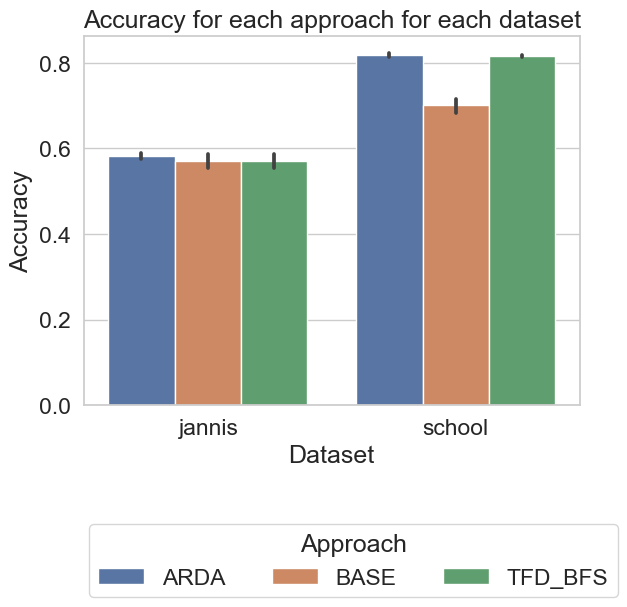

In [21]:

display(accuracy.head())

sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

ax = sns.barplot(data=accuracy, x="data_label", y="accuracy", hue="approach")

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(1.1, -0.55), loc=4, ncol=3, title="Approach")
ax.set_title("Accuracy for each approach for each dataset")

# plt.savefig('plots/2024/accuracy_1.png', dpi=300, bbox_inches="tight")




## Accuracy all algorithms

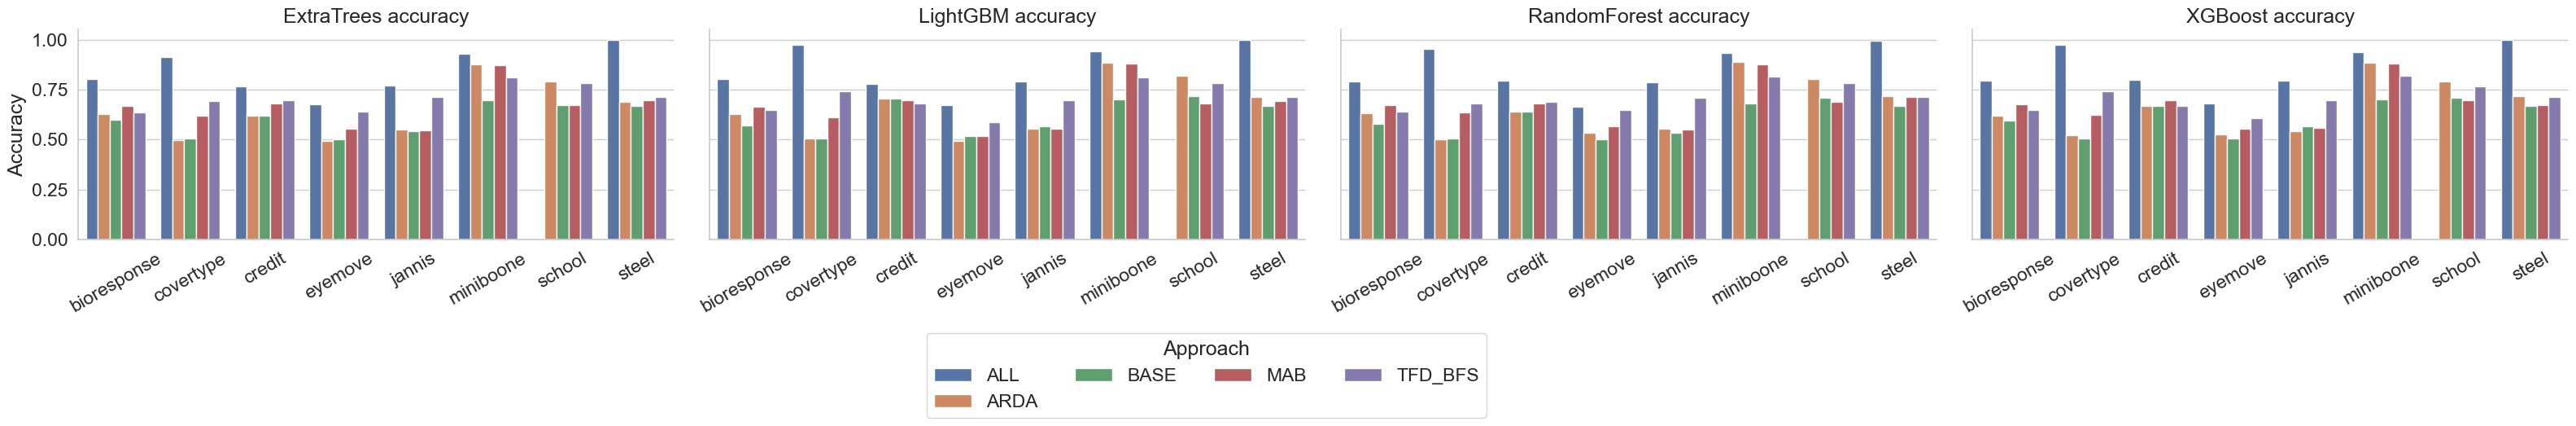

In [14]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[~accuracy['data_label'].isin(['air', 'superconduct', 'yprop'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=2)

g.set_titles("{col_name} accuracy")
g.set_xlabels('')
g.set_ylabels('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.8, -0.4), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_8_classification_optimised_2.png', dpi=300, bbox_inches="tight")


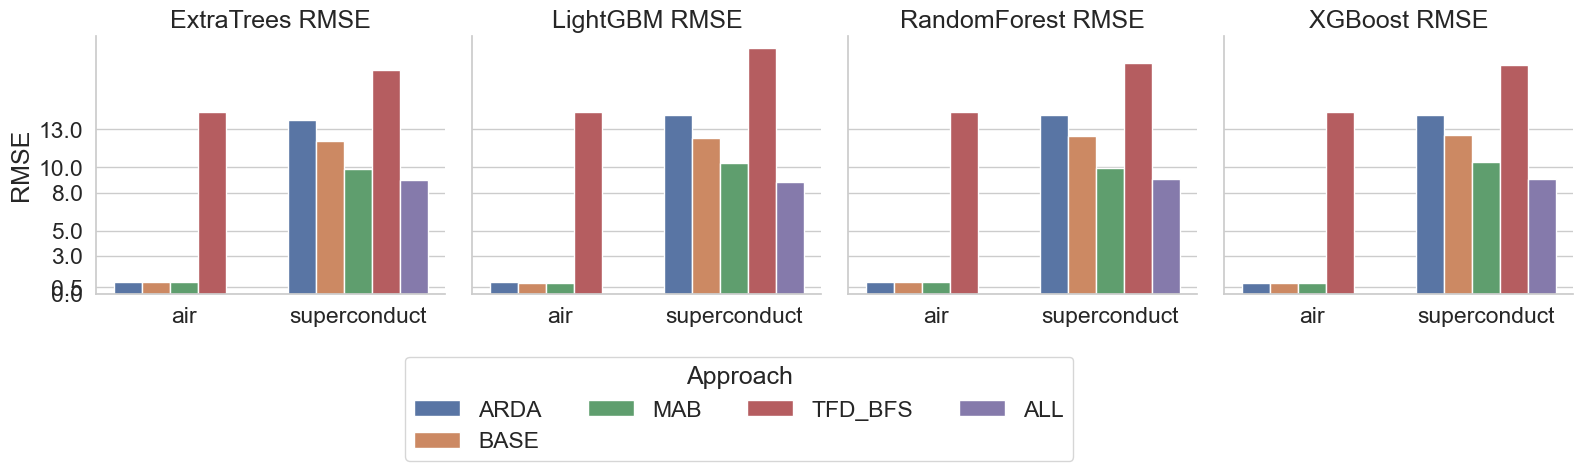

In [15]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[accuracy['data_label'].isin(['superconduct', 'air'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} RMSE")
g.set_xlabels('')
g.set_ylabels('RMSE')
plt.yticks([0,0.5, 3, 5, 8, 10, 13])


loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_2_regression_optimised_2.png', dpi=300, bbox_inches="tight")


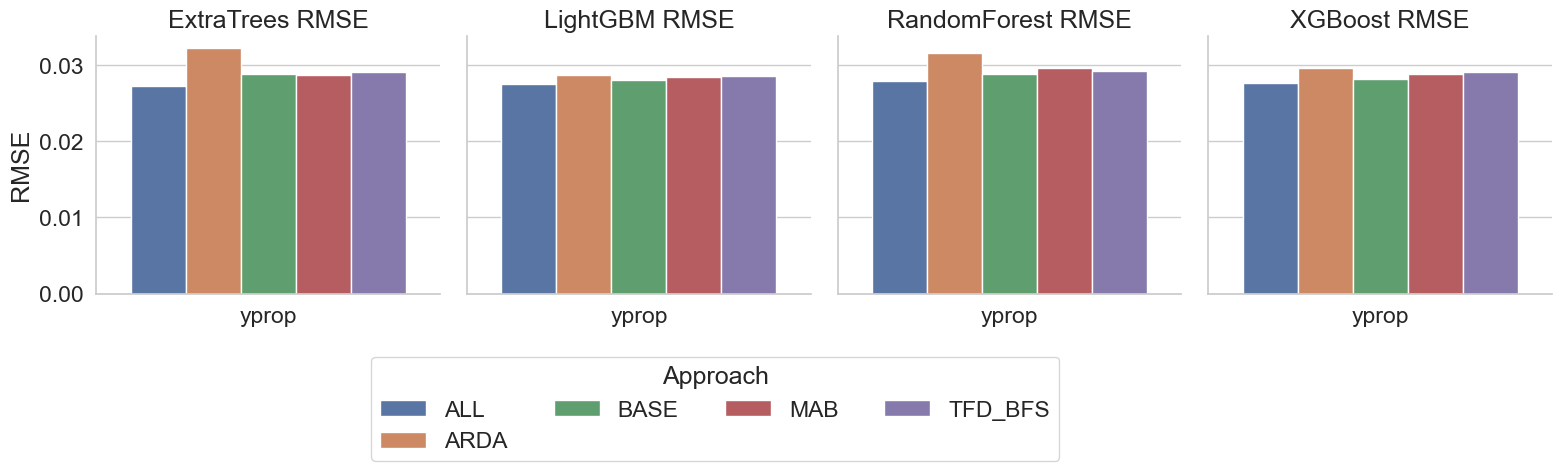

In [15]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[accuracy['data_label'].isin(['yprop'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} RMSE")
g.set_xlabels('')
g.set_ylabels('RMSE')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_yprop_optimised.png', dpi=300, bbox_inches="tight")


## Total time - one algorithm

,data_label,approach,algorithm,accuracy,total_time
0,bioresponse,ARDA,ExtraTrees,0.723333,2.077434
1,bioresponse,ARDA,LightGBM,0.658333,2.077434
2,bioresponse,ARDA,RandomForest,0.703333,2.077434
3,bioresponse,ARDA,XGBoost,0.661667,2.077434
4,bioresponse,BASE,ExtraTrees,0.711790,-inf


/Users/andra/Developer/auto-data-augmentation/env/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 1.0, 'Total runtime (log scale) for each approach for each dataset')

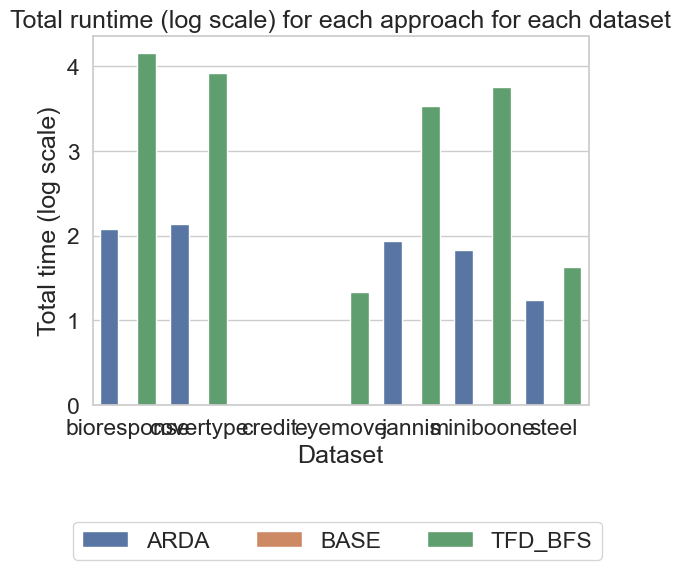

In [48]:


display(total_time.head())

sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

# g = sns.catplot(x="data_label", y="accuracy", hue="approach", data=accuracy, kind="bar", height=4,
#                order=algs)

ax = sns.barplot(data=total_time, x="data_label", y="total_time", hue="approach")


# g.set_titles("{col_name}")
ax.set_xlabel('Dataset')
ax.set_ylabel('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

# g.set_xticklabels(labels, rotation=30)
# g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(1.05, -0.45), loc=4, ncol=3)
ax.set_title("Total runtime (log scale) for each approach for each dataset")

# plt.savefig('plots/2024/total_time_1.png', dpi=300, bbox_inches="tight")



## Total time - all algorithms

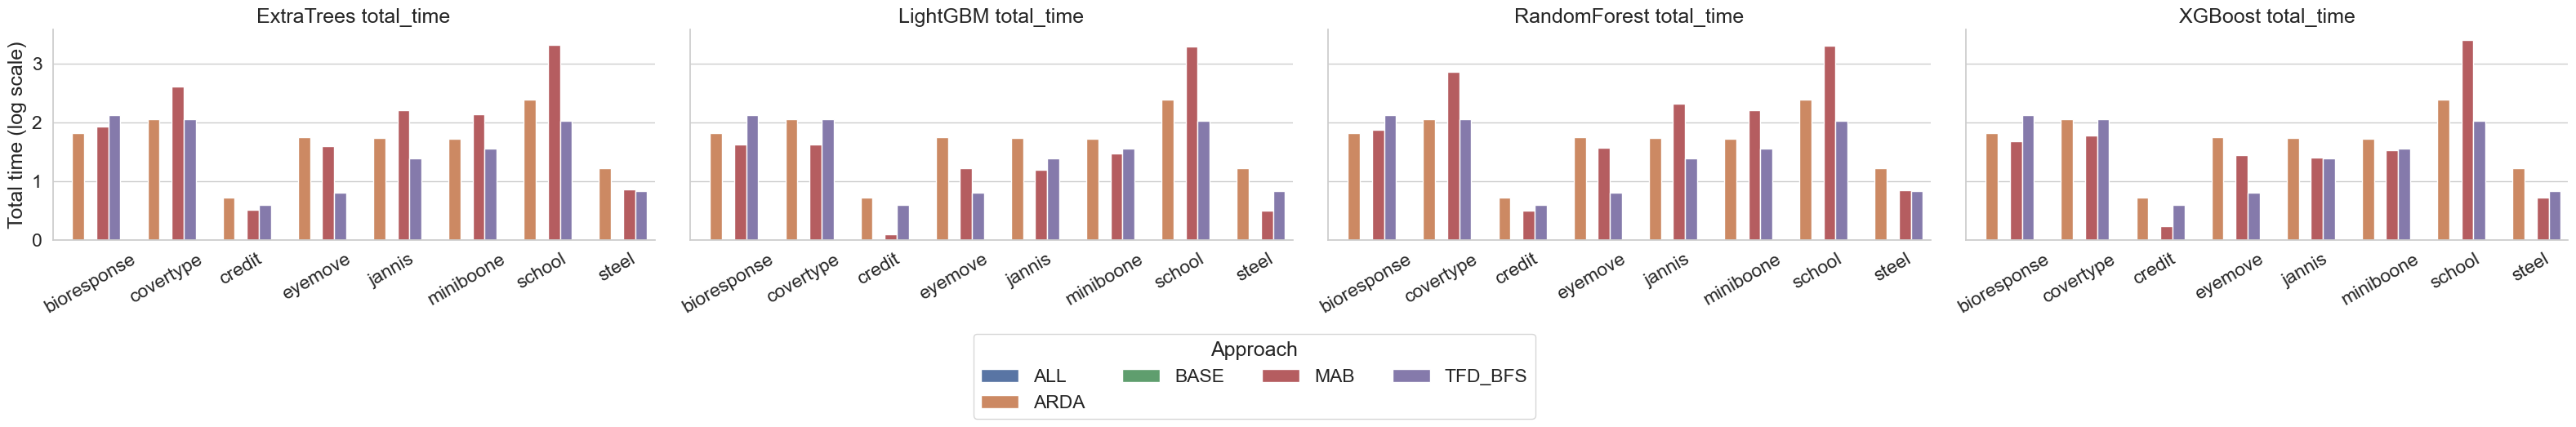

In [16]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

taux = total_time[~total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=taux, kind="bar", height=4, aspect=2)

g.set_titles("{col_name} total_time")
g.set_xlabels('')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.7, -0.4), ncol=4, title="Approach")

g.savefig('plots/2024/total_time_8_classification_optimised.png', dpi=300, bbox_inches="tight")


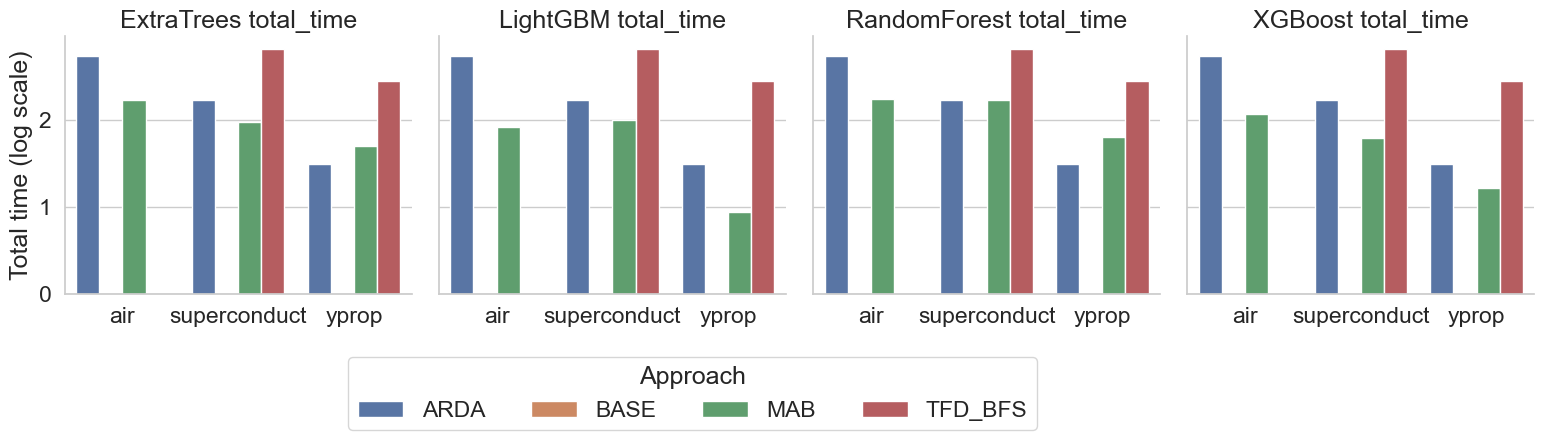

In [134]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

taux = total_time[total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=taux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} total_time")
g.set_xlabels('')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")

g.savefig('plots/2024/total_time_3_regression.png', dpi=300, bbox_inches="tight")


## Features - one algorithm

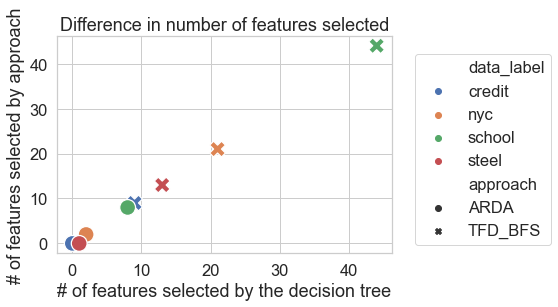

In [100]:
sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

ax = sns.scatterplot(data=feat_df, x="number_features_importance", 
                     y="number_join_path_features", hue="data_label", 
                     style="approach", s=250)

ax.set_xlabel("# of features selected by the decision tree")
ax.set_ylabel("# of features selected by approach")
ax.set_title("Difference in number of features selected")

hh, ll = plt.gca().get_legend_handles_labels()
plt.legend(hh, ll, bbox_to_anchor=(1.5, 0), loc=4, ncol=1)

# plt.savefig('plots/2024/nr_features_1.png', dpi=300, bbox_inches="tight")



## Features - all algorithms

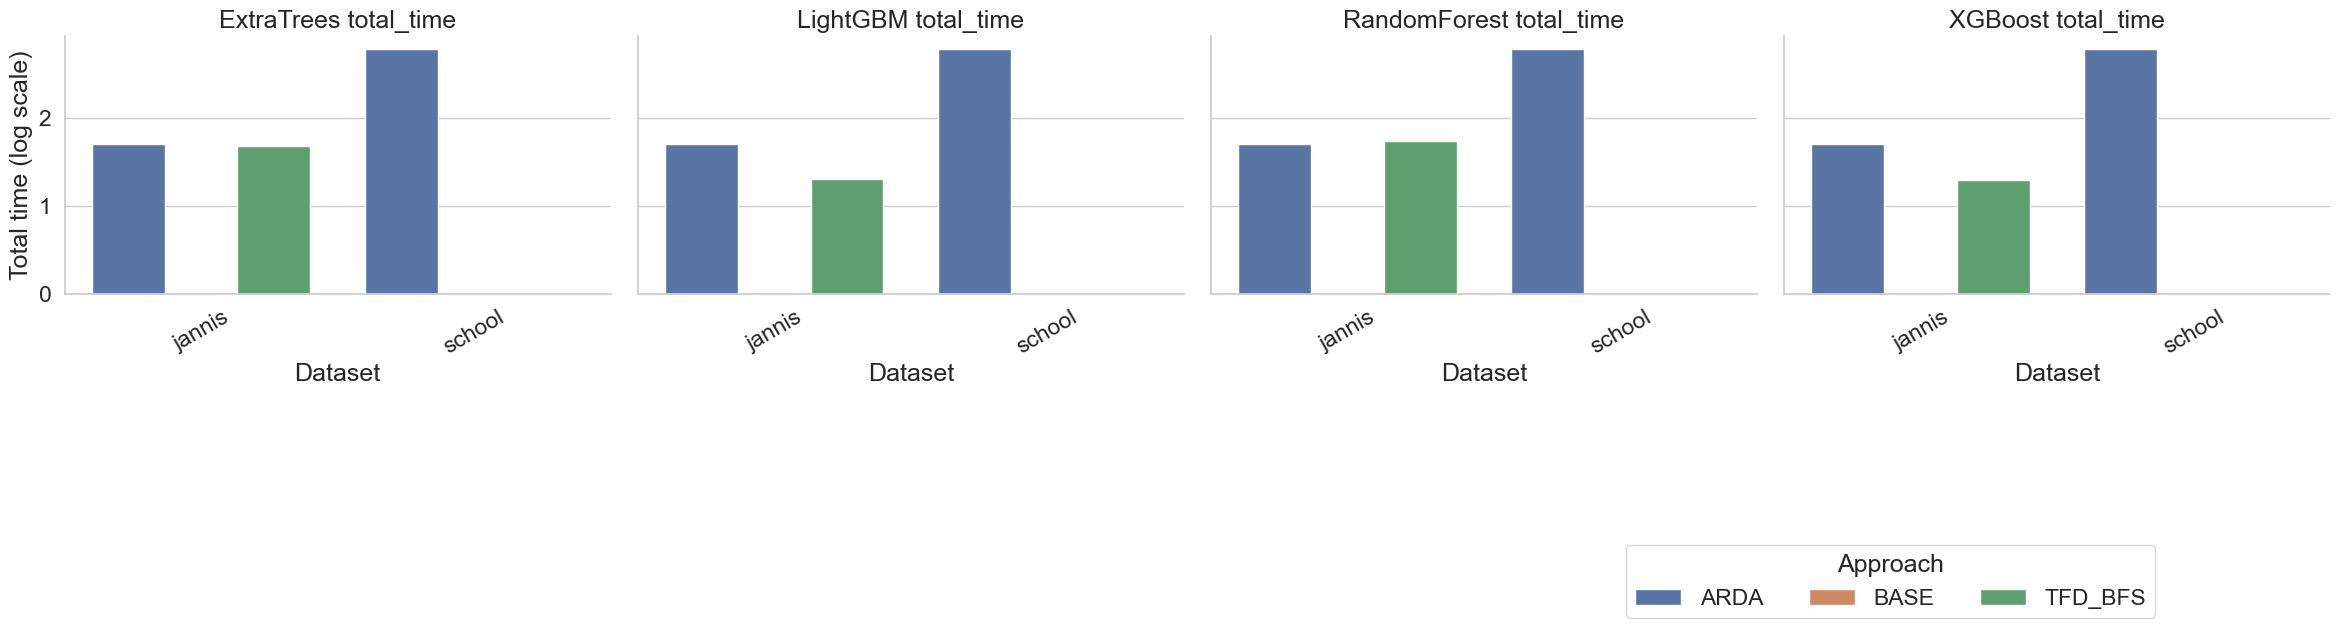

In [24]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=total_time, kind="bar", height=4, aspect=1.5)

g.set_titles("{col_name} total_time")
g.set_xlabels('Dataset')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3, title="Approach")

# g.savefig('plots/accuracy-all-big.pdf', dpi=300, bbox_inches="tight")


# 6. Tune threshold - value_ratio

## Analyse data

In [41]:
# read data

value_ratio_result_fileine = "all_results_value_ratio_tuning.csv"
filepath_vr = os.path.join(folder_name, f"{dataset_path}/{value_ratio_result_fileine}")

df_vr = pd.read_csv(filepath_vr)
df_vr.drop(columns=['join_time', 'depth', 'redundancy_threshold', 'rank', 'algorithm', 'approach'], inplace=True)

df_vr

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold
0,housing.csv--Borough-capital_projects2.csv,nyc,67.596903,NaN,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,67.596903,NaN,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15
2,base.csv--DBN-math.csv,school,213.776966,NaN,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15
3,base.csv--DBN-qr.csv,school,213.776966,NaN,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,213.776966,NaN,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15
...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,28.494592,NaN,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95
163,housing.csv--Borough-film_permits.csv,nyc,50.908460,NaN,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00
164,housing.csv--Borough-capital_projects2.csv,nyc,50.908460,NaN,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,36.926676,NaN,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00


## Fix time 

In [42]:
df_vr['feature_selection_time'] = df_vr['total_time']
df_vr['total_time'] = df_vr['feature_selection_time'] + df_vr['train_time']
df_vr

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold
0,housing.csv--Borough-capital_projects2.csv,nyc,68.891069,67.596903,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,69.623234,67.596903,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15
2,base.csv--DBN-math.csv,school,215.594723,213.776966,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15
3,base.csv--DBN-qr.csv,school,214.423504,213.776966,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,215.780213,213.776966,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15
...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,30.723356,28.494592,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95
163,housing.csv--Borough-film_permits.csv,nyc,52.597664,50.908460,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00
164,housing.csv--Borough-capital_projects2.csv,nyc,51.999809,50.908460,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,37.921177,36.926676,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00


## Process data

In [51]:
number_of_features, features = parse_feature_importance(df_vr)
df_vr['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(df_vr)
df_vr['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(df_vr)
df_vr['nr_common_features'] = nr_common_features
df_vr['different_features'] = difference

df_vr

[11, 19, 20, 6, 23, 8, 37, 22, 12, 19, 11, 19, 20, 6, 29, 8, 42, 37, 41, 22, 12, 7, 28, 11, 19, 20, 37, 22, 41, 12, 9, 24, 11, 19, 20, 23, 22, 12, 9, 16, 11, 19, 23, 20, 6, 47, 23, 8, 22, 22, 56, 12, 7, 9, 27, 11, 19, 8, 20, 6, 44, 22, 22, 12, 9, 20, 11, 19, 8, 20, 37, 22, 22, 12, 16, 11, 19, 23, 20, 44, 20, 22, 12, 7, 9, 20, 11, 19, 8, 20, 23, 22, 22, 56, 12, 9, 24, 11, 19, 20, 6, 23, 22, 22, 56, 12, 9, 16, 11, 19, 6, 29, 8, 22, 22, 12, 7, 9, 16, 11, 19, 22, 22, 12, 7, 23, 11, 19, 29, 8, 22, 22, 14, 7, 9, 16, 11, 16, 22, 22, 12, 7, 28, 16, 11, 18, 15, 22, 12, 8, 9, 14, 16, 11, 22, 12, 17, 16, 11, 22, 12, 9, 22, 16, 11, 12, 16]
[11, 19, 20, 6, 23, 8, 37, 22, 12, 19, 11, 19, 20, 6, 29, 8, 42, 37, 41, 22, 12, 7, 28, 11, 19, 20, 37, 22, 41, 12, 9, 24, 11, 19, 20, 23, 22, 12, 9, 16, 11, 19, 23, 20, 6, 47, 23, 8, 22, 22, 56, 12, 7, 9, 27, 11, 19, 8, 20, 6, 44, 22, 22, 12, 9, 20, 11, 19, 8, 20, 37, 22, 22, 12, 16, 11, 19, 23, 20, 44, 20, 22, 12, 7, 9, 20, 11, 19, 8, 20, 23, 22, 22, 56, 12, 9

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
0,housing.csv--Borough-capital_projects2.csv,nyc,68.891069,67.596903,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15,11,11,11,{}
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,69.623234,67.596903,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15,19,19,19,{}
2,base.csv--DBN-math.csv,school,215.594723,213.776966,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15,20,20,20,{}
3,base.csv--DBN-qr.csv,school,214.423504,213.776966,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15,6,6,6,{}
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,215.780213,213.776966,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15,23,23,23,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,30.723356,28.494592,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95,22,22,22,{}
163,housing.csv--Borough-film_permits.csv,nyc,52.597664,50.908460,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00,16,16,16,{}
164,housing.csv--Borough-capital_projects2.csv,nyc,51.999809,50.908460,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00,11,11,11,{}
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,37.921177,36.926676,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00,12,12,12,{}


## Plot

In [55]:
threshold = df_vr.groupby(['cutoff_threshold', 'data_label'])[['total_time', 'accuracy']].max().reset_index()
threshold 


,cutoff_threshold,data_label,total_time,accuracy
0,0.15,nyc,69.623234,0.852130
1,0.15,school,217.171951,1.000000
2,0.15,steel,23.865264,0.777713
3,0.20,nyc,63.183314,0.851685
4,0.20,school,318.169488,1.000000
...,...,...,...,...
60,0.95,school,44.272763,1.000000
61,0.95,steel,30.723356,0.800261
62,1.00,nyc,52.597664,0.833256
63,1.00,school,37.921177,1.000000


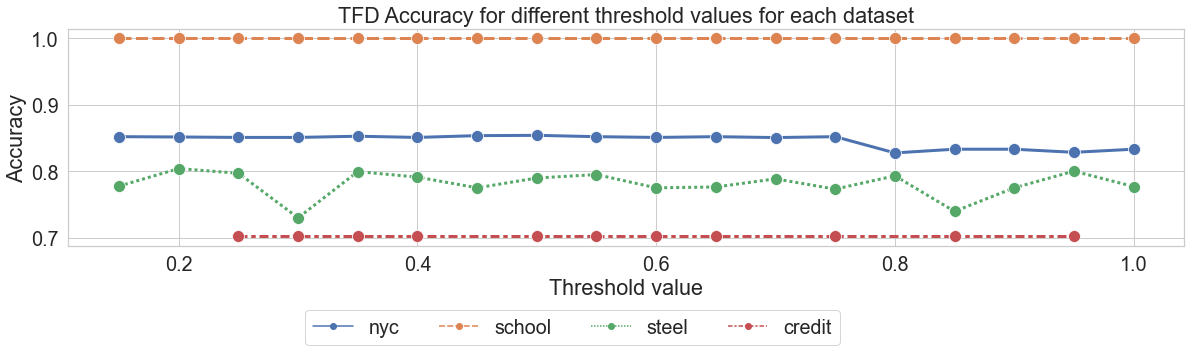

In [84]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(20, 4))

# ax = sns.barplot(data=threshold, x="cutoff_threshold", y="accuracy", hue="data_label")

# ax = sns.scatterplot(data=threshold, x="cutoff_threshold", 
#                      y="accuracy",  
#                      style="data_label", s=250)
ax = sns.lineplot(data=threshold, x="cutoff_threshold", 
                     y="accuracy", hue="data_label",
                     style="data_label", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('Threshold value')
ax.set_ylabel('Accuracy')

hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -0.5), loc=4, ncol=4)
ax.set_title("TFD Accuracy for different threshold values for each dataset")

plt.savefig('plots/2024/threshold_1.png', dpi=300, bbox_inches="tight")


# 7. Ablation

## Read data

In [147]:
# read data

ablation_filename = "ablation_study_0.5.csv"
filepath_abl = os.path.join(folder_name, f"{dataset_path}/{ablation_filename}")

ablation = pd.read_csv(filepath_abl)

ablation

,study,nyc_paths,nyc_runtime,school_paths,school_runtime,credit_paths,credit_runtime,steel_paths,steel_runtime
0,enumerate,11,16.090323,1104,1.818853,1,0.365223,139,0.456157
1,enumerate_join,11,97.804418,1104,894.550517,1,2.249067,139,70.750071
2,enumerate_prune,5,68.508469,76,103.639486,1,3.243296,139,76.397723
3,enumerate_join_prune_fs,5,94.340995,76,1100.108041,1,2.793950,69,161.210917
4,enumerate_join_prune_fs_rank_jk,5,103.161171,41,1012.976641,1,3.443817,38,176.144711


## Create dataframes for plots

In [148]:
ablation_paths = ablation[['study', 'nyc_paths', 'school_paths', 'credit_paths', 'steel_paths']]
ablation_paths = ablation_paths.set_index('study').stack().reset_index(name="value").rename(columns={'level_1': 'type'})
ablation_paths

,study,type,value
0,enumerate,nyc_paths,11
1,enumerate,school_paths,1104
2,enumerate,credit_paths,1
3,enumerate,steel_paths,139
4,enumerate_join,nyc_paths,11
5,enumerate_join,school_paths,1104
6,enumerate_join,credit_paths,1
7,enumerate_join,steel_paths,139
8,enumerate_prune,nyc_paths,5
9,enumerate_prune,school_paths,76


In [149]:
ablation_runtime = ablation[['study', 'nyc_runtime', 'school_runtime', 'credit_runtime', 'steel_runtime']]
ablation_runtime = ablation_runtime.set_index('study').stack().reset_index(name="value").rename(columns={'level_1': 'type'})
ablation_runtime

,study,type,value
0,enumerate,nyc_runtime,16.090323
1,enumerate,school_runtime,1.818853
2,enumerate,credit_runtime,0.365223
3,enumerate,steel_runtime,0.456157
4,enumerate_join,nyc_runtime,97.804418
5,enumerate_join,school_runtime,894.550517
6,enumerate_join,credit_runtime,2.249067
7,enumerate_join,steel_runtime,70.750071
8,enumerate_prune,nyc_runtime,68.508469
9,enumerate_prune,school_runtime,103.639486


## Plots

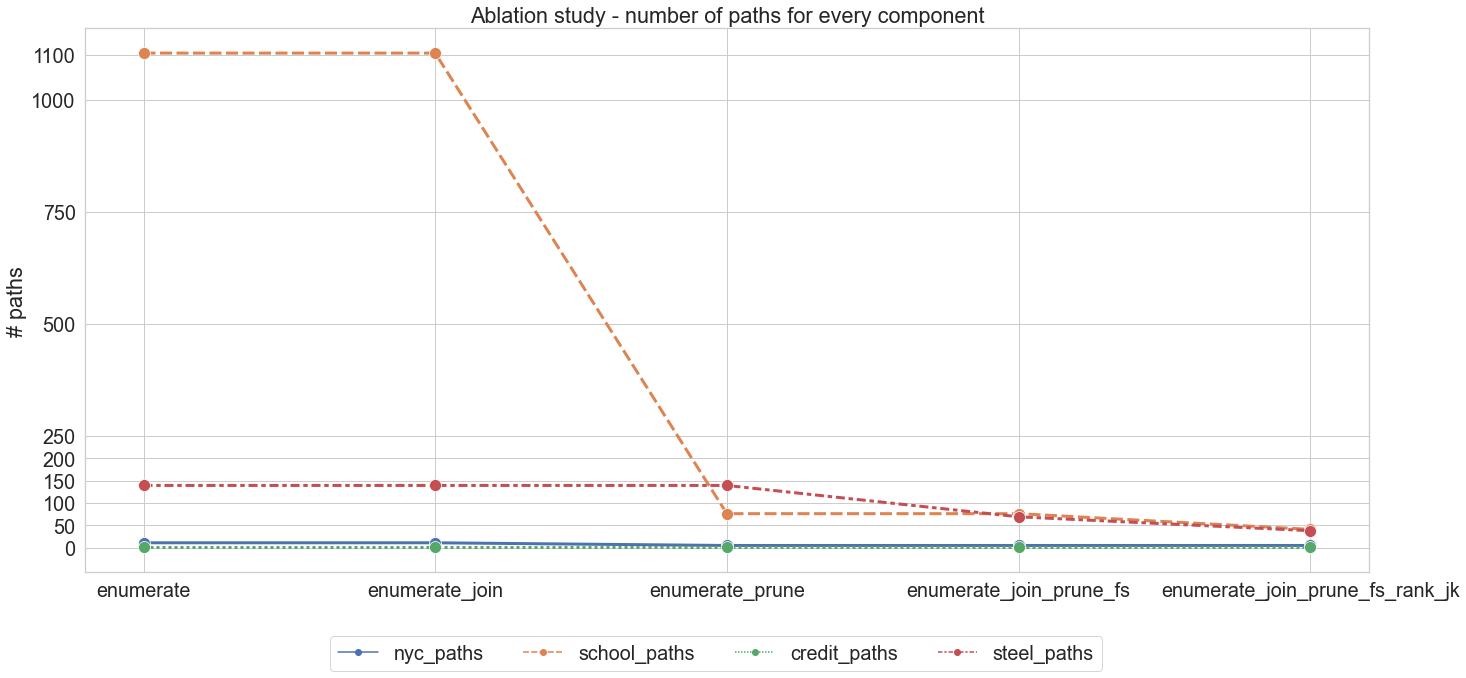

In [152]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(23, 10))

ax = sns.lineplot(data=ablation_paths, x="study", 
                     y="value", hue="type",
                     style="type", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('')
ax.set_ylabel('# paths')

ax.set_yticks([0, 50, 100, 150, 200, 250, 500, 750, 1000, 1100])


hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.8, -0.2), loc=4, ncol=4)
ax.set_title("Ablation study - number of paths for every component")

plt.savefig('plots/2024/ablation_paths_1.png', dpi=300, bbox_inches="tight")


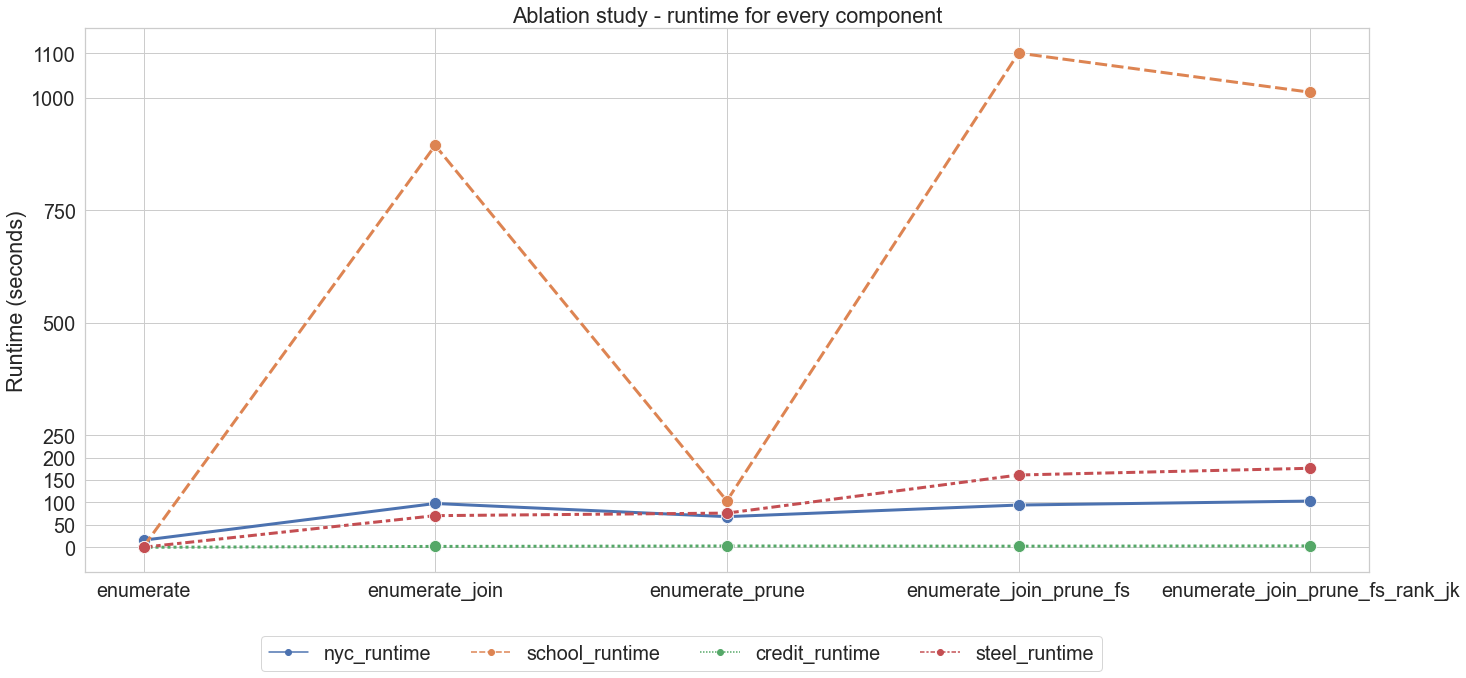

In [153]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(23, 10))

ax = sns.lineplot(data=ablation_runtime, x="study", 
                     y="value", hue="type",
                     style="type", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('')
ax.set_ylabel('Runtime (seconds)')

ax.set_yticks([0, 50, 100, 150, 200, 250, 500, 750, 1000, 1100])


hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.8, -0.2), loc=4, ncol=4)
ax.set_title("Ablation study - runtime for every component")

plt.savefig('plots/2024/ablation_runtime_1.png', dpi=300, bbox_inches="tight")


In [3]:
# get original (base) table name from dataset name 

def shorten_dataset_name_join(data):
    if 'other-data' in data:
        partition = data.partition('other-data')[2]
        split = partition.split('/')[-1]
    else:
        split = data.split('/')[0]
    return split

def half_time(data):
    if 'other-data' in data:
        partition = data.partition('other-data')[2]
        split = partition.split('/')[-1]
    else:
        split = data.split('/')[0]
    return split

dataframe['dataset'] = dataframe['data_path'].apply(lambda x: shorten_dataset_name_join(x))

dataframe


,approach,data_path,algorithm,depth,accuracy,join_time,train_time,total_time,feature_importances,fs_time,dataset
0,all-in-path,football/football.csv/id--football/differences...,CART,2.0,0.798761,2.075651,0.081938,2.157589,{'strong_score': 1.0},NaN,football
1,all-in-path,football/football.csv/id--football/differences...,ID3,2.0,0.519043,2.075651,269.792025,271.867676,{},NaN,football
2,all-in-path,football/football.csv/id--football/differences...,XGBoost,1.0,0.784404,2.075651,0.772123,2.847774,"{'date': 0.033, 'weak_team': 0.018, 'dif_overa...",NaN,football
3,best-ranked,football/football.csv/id--football/differences...,CART,4.0,0.785202,2.075651,0.087464,2.163115,"{'date': 0.022, 'dif_midfield': 0.016, 'id': 0...",NaN,football
4,best-ranked,football/football.csv/id--football/differences...,ID3,4.0,0.528358,2.075651,173.252891,175.328542,{},NaN,football
...,...,...,...,...,...,...,...,...,...,...,...
103,non-aug,other-data/decision-trees-split/titanic,ID3,2.0,0.383783,NaN,28.246128,28.246128,{},NaN,titanic
104,non-aug,other-data/decision-trees-split/titanic,XGBoost,1.0,0.562484,NaN,0.140772,0.140772,"{'PassengerId': 0.491, 'TicketId': 0.509}",NaN,titanic
105,non-aug,other-data/data/WebKP 2,CART,1.0,0.470925,NaN,0.012028,0.012028,{'webpage_id': 1.0},NaN,WebKP 2
106,non-aug,other-data/data/WebKP 2,ID3,2.0,0.091131,NaN,13.375112,13.375112,{},NaN,WebKP 2


In [4]:
df1 = dataframe[(dataframe['approach']=='best-ranked') | (dataframe['approach']=='all-in-path')]

df1['join_time'] = dataframe.apply(lambda x: x['join_time']/2, axis=1)
df1['total_time'] = dataframe.apply(lambda x: x['total_time']/2, axis=1)
df1['train_time'] = dataframe.apply(lambda x: x['train_time']/2, axis=1)

df2 = dataframe[(dataframe['approach']!='best-ranked')  & (dataframe['approach']!='all-in-path')]

df = pd.concat([df1, df2])
df['approach'].unique()


/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['join_time'] = dataframe.apply(lambda x: x['join_time']/2, axis=1)
/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['total_time'] = dataframe.apply(lambda x: x['total_time']/2, axis=1)
/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:5: SettingWithCopyWarning: 
A val

array(['all-in-path', 'best-ranked', 'join_all', 'arda', 'join_all_ffs',
       'non-aug'], dtype=object)

In [4]:
best_ranked = dataframe[dataframe['approach']=='best-ranked']
# display(best_ranked)

all_path = dataframe[dataframe['approach']=='all-in-path']
# display(all_path)

join_all = dataframe[dataframe['approach']=='join_all']
# display(join_all)

arda = dataframe[dataframe['approach']=='arda']
# display(best_ranked)

join_all_ffs = dataframe[dataframe['approach']=='join_all_ffs']
# display(all_path)

non_aug = dataframe[dataframe['approach']=='non-aug']
# display(join_all)


best_ranked_df = best_ranked.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='accuracy').reset_index()
display(best_ranked_df)


,dataset,algorithm,depth,approach,accuracy
0,football,CART,2.0,best-ranked,6.190797
1,football,ID3,4.0,best-ranked,170.645855
2,football,XGBoost,1.0,best-ranked,6.553480
3,steel-plate-fault,CART,9.0,best-ranked,85.162665
4,steel-plate-fault,ID3,4.0,best-ranked,509.314594
5,steel-plate-fault,XGBoost,11.0,best-ranked,89.028154
6,titanic,CART,3.0,best-ranked,0.588195
7,titanic,ID3,2.0,best-ranked,169.759674
8,titanic,XGBoost,1.0,best-ranked,0.890371


In [7]:
# train time
total_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
    dff = dff.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()
    if total_time is None:
        total_time = dff
    else:
        total_time = pd.concat([total_time, dff])
        
display(total_time)

,dataset,algorithm,depth,approach,total_time
0,football,CART,6.0,arda,31.876689
1,football,ID3,4.0,arda,72.093538
2,football,XGBoost,2.0,arda,32.415981
3,steel-plate-fault,CART,4.0,arda,217.050151
4,steel-plate-fault,ID3,8.0,arda,218.328975
5,steel-plate-fault,XGBoost,1.0,arda,217.477362
6,titanic,CART,1.0,arda,5.859683
7,titanic,ID3,2.0,arda,6.029064
8,titanic,XGBoost,1.0,arda,6.085378
0,football,CART,10.0,join_all,0.408521


In [8]:
depth = None
for approach in dataframe['approach'].unique():
    dff = dataframe[dataframe['approach']==approach]
    dff = dff.groupby(['dataset', 'algorithm', 'approach'])['depth'].max().to_frame(name='depth').reset_index()
    if depth is None:
        depth = dff
    else:
        depth = pd.concat([depth, dff])

In [9]:
join_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
    dff = df[(df['dataset']!='PubMed_Diabetes') & (df['dataset']!='CiteSeer') & (df['dataset']!='CORA')]
    dff = dff.groupby(['dataset', 'algorithm', 'depth', 'approach'])['join_time'].max().to_frame(name='join_time').reset_index()
    if join_time is None:
        join_time = dff
    else:
        join_time = pd.concat([join_time, dff])

In [10]:
# Separate into 2 datasets
small_datasets = ['football', 'steel-plate-fault', 'titanic']
big_datasets = ['CORA', 'WebKP 2', 'CiteSeer']

,dataset,algorithm,depth,approach,accuracy
3,CiteSeer,CART,2.0,best-ranked,0.230067
13,football,ID3,4.0,best-ranked,0.528358
16,steel-plate-fault,ID3,4.0,best-ranked,0.355155
4,CiteSeer,ID3,2.0,best-ranked,0.201704
19,titanic,ID3,2.0,best-ranked,0.383783


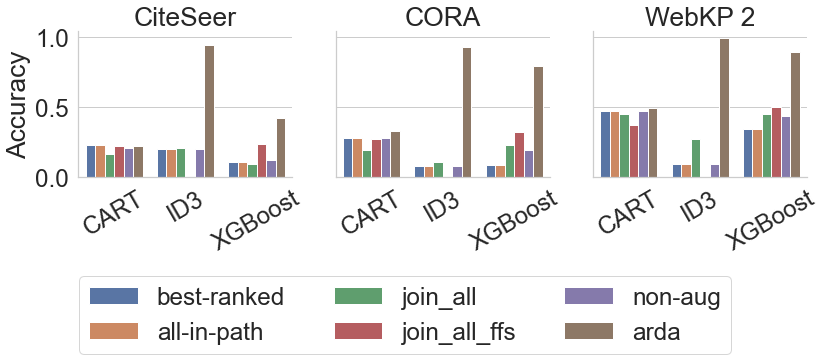

In [16]:
# Accuracy of BestRank, JoinAll and Non-Aug

# BIG DATASETS

display(accuracy.head())

label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2, 'join_all_ffs': 3, 'non-aug': 4, 'arda': 5}

accuracy.sort_values(by=['algorithm'], ascending=True, inplace=True)
accuracy.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)

accuracy_filtered = accuracy[accuracy["dataset"].isin(big_datasets)]
# accuracy_filtered = accuracy_filtered[accuracy_filtered["approach"] != "arda"]


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="accuracy", hue="approach", col="dataset", data=accuracy_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/accuracy-all-big.pdf', dpi=300, bbox_inches="tight")




,dataset,algorithm,depth,approach,total_time
0,football,CART,2.0,best-ranked,6.190797
1,football,ID3,4.0,best-ranked,170.645855
2,football,XGBoost,1.0,best-ranked,6.553480
3,steel-plate-fault,CART,9.0,best-ranked,85.162665
4,steel-plate-fault,ID3,4.0,best-ranked,509.314594


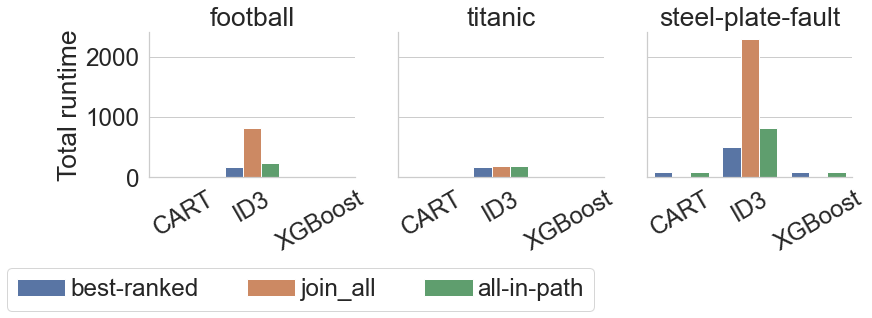

In [16]:
# Accuracy of BestRank, JoinAll and Non-Aug

best_ranked = df[df['approach']=='best-ranked']
# display(best_ranked)

all_path = df[df['approach']=='all-in-path']
# display(all_path)

join_all = df[df['approach']=='join_all']
# display(join_all)

best_ranked_df = best_ranked.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

all_path_df = all_path.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

join_all_df = join_all.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

concat_df = pd.concat([best_ranked_df, all_path_df, join_all_df])

display(concat_df.head())

# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

concat_df.sort_values(by=['algorithm'], ascending=True, inplace=True)
# concat_df.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=concat_df, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total runtime')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.2, -1), loc=4, ncol=3, handletextpad=0.2)

g.savefig('plots/runtime-all.pdf', dpi=300, bbox_inches="tight")





,dataset,algorithm,depth,approach,join_time
0,football,CART,1.0,non-aug,NaN
18,steel-plate-fault,CART,6.0,all-in-path,85.046816
19,steel-plate-fault,CART,6.0,join_all,0.186446
20,steel-plate-fault,CART,6.0,non-aug,NaN
21,steel-plate-fault,CART,9.0,best-ranked,85.046816
...,...,...,...,...,...
49,titanic,XGBoost,2.0,join_all,0.064785
11,football,XGBoost,1.0,all-in-path,6.125426
12,football,XGBoost,1.0,best-ranked,6.125426
45,titanic,XGBoost,1.0,all-in-path,0.513113


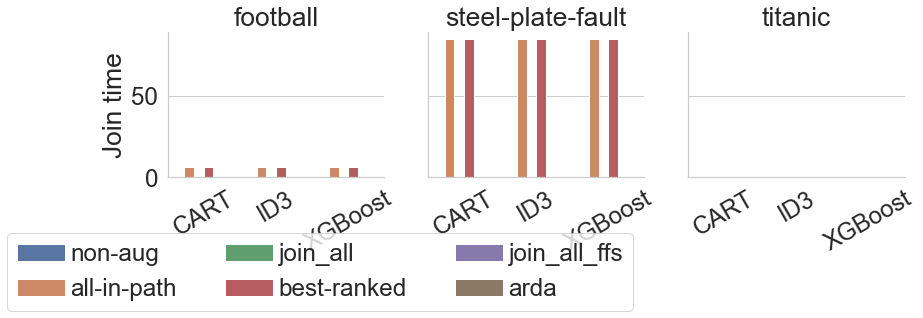

In [17]:



# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

### SMALL DATASETS JOIN TIME

join_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
# join_time.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)
join_time_filtered = join_time[join_time['dataset'].isin(small_datasets)]

display(join_time)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="join_time", hue="approach", col="dataset", data=join_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Join time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.2, -1), loc=4, ncol=3, handletextpad=0.2)

g.savefig('plots/join-time-all.pdf', dpi=300, bbox_inches="tight")




In [18]:
train_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
#     dff = dataframe[(dataframe['dataset']!='PubMed_Diabetes') & (dataframe['dataset']!='CiteSeer') & (dataframe['dataset']!='CORA')]
    dff = dff.groupby(['dataset', 'algorithm', 'approach'])['train_time'].max().to_frame(name='train_time').reset_index()
    if train_time is None:
        train_time = dff
    else:
        train_time = pd.concat([train_time, dff])

,dataset,algorithm,approach,train_time
0,football,CART,arda,-2.721879+0.000000j
3,steel-plate-fault,CART,arda,-2.811296+0.000000j
6,titanic,CART,best-ranked,-2.589174+0.000000j
6,titanic,CART,arda,-2.680222+0.000000j
3,steel-plate-fault,CART,best-ranked,-2.155470+0.000000j
0,football,CART,best-ranked,-2.727676+0.000000j
4,steel-plate-fault,ID3,arda,0.291886+0.000000j
7,titanic,ID3,arda,-1.435784+0.000000j
1,football,ID3,arda,3.695920+0.000000j
1,football,ID3,best-ranked,5.103035+0.000000j


/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


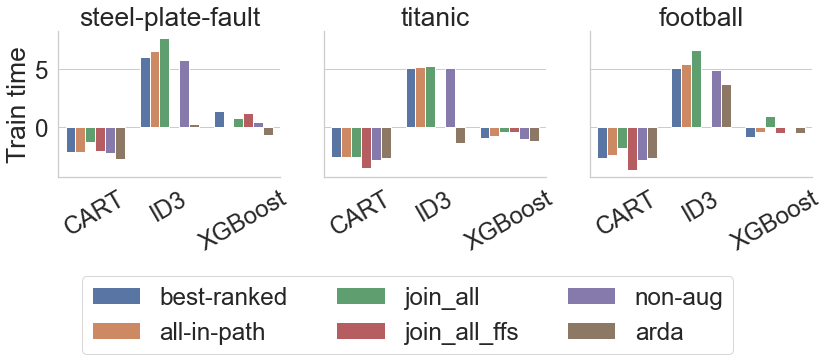

In [20]:
# Accuracy of BestRank, JoinAll and Non-Aug
from cmath import log

# display(train_time)

#### TRAIN TIME small datasets
label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2, 'join_all_ffs': 3, 'non-aug': 4, 'arda': 5}

train_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
train_time_filtered = train_time[train_time['dataset'].isin(small_datasets)]
train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
display(train_time_filtered[(train_time_filtered['approach'] == 'best-ranked') | (train_time_filtered['approach'] == 'arda')])
train_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="train_time", hue="approach", col="dataset", data=train_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Train time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/train-time-all-small.pdf', dpi=300, bbox_inches="tight")

/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/193570243.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to 

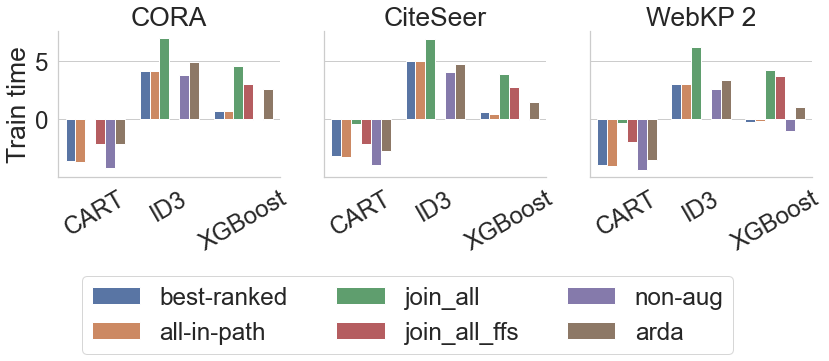

In [27]:
# Accuracy of BestRank, JoinAll and Non-Aug

from cmath import log
# display(train_time)

#### TRAIN TIME BIG datasets
train_time_filtered
train_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
train_time_filtered = train_time[train_time['dataset'].isin(big_datasets)]
# train_time_filtered = train_time_filtered[train_time_filtered['approach'] != 'join_all']
train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
train_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="train_time", hue="approach", col="dataset", data=train_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Train time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/train-time-all-big.pdf', dpi=300, bbox_inches="tight")

,dataset,algorithm,approach,depth
0,football,CART,arda,6.0
3,steel-plate-fault,CART,all-in-path,6.0
4,titanic,CART,join_all_ffs,2.0
2,steel-plate-fault,CART,join_all_ffs,13.0
6,titanic,CART,all-in-path,5.0


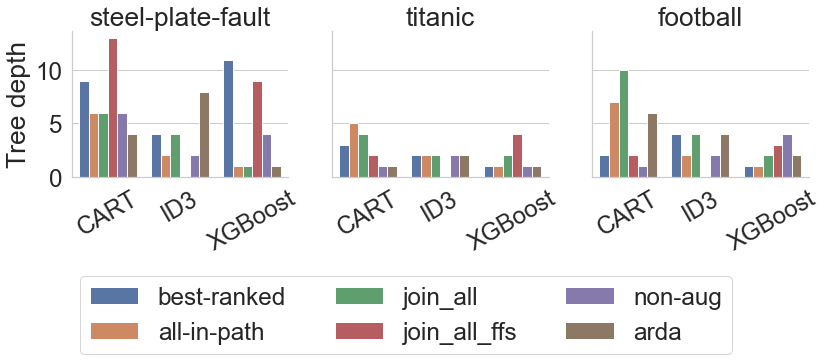

In [17]:

display(depth.head())

# DEPTH SMALL labels
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

depth.sort_values(by=['algorithm'], ascending=True, inplace=True)
depth_filtered = depth[depth["dataset"].isin(small_datasets)]
depth_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="depth", hue="approach", col="dataset", data=depth_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Tree depth')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/depth-all-small.png', dpi=300, bbox_inches="tight")





In [16]:
display(depth.head())

# DEPTH BIG labels
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

depth.sort_values(by=['algorithm'], ascending=True, inplace=True)
depth_filtered = depth[depth["dataset"].isin(big_datasets)]
depth_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="depth", hue="approach", col="dataset", data=depth_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Tree depth')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/depth-all-big.pdf', dpi=300, bbox_inches="tight")


,dataset,algorithm,approach,depth
0,football,CART,arda,6.0
0,football,CART,all-in-path,7.0
0,football,CART,join_all,10.0
6,titanic,CART,non-aug,1.0
3,steel-plate-fault,CART,arda,4.0


/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


ValueError: min() arg is an empty sequence

/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


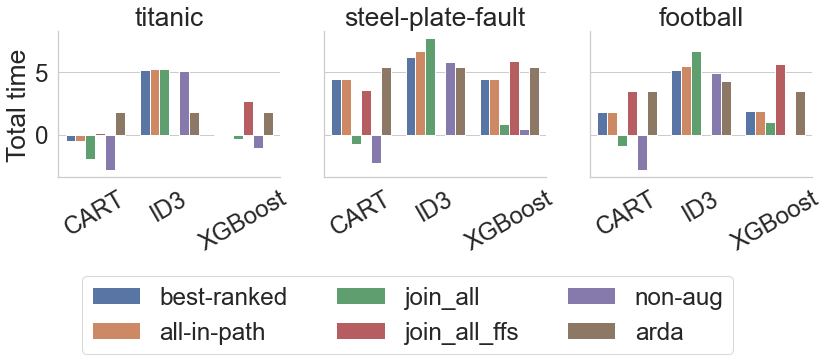

In [15]:
# Accuracy of BestRank, JoinAll and Non-Aug

from cmath import log
# display(train_time)

#### TOTAL TIME SMALL datasets
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

total_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
total_time_filtered = total_time[total_time['dataset'].isin(small_datasets)]
# total_time_filtered = total_time_filtered[total_time_filtered['approach'] != 'join_all']
total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
total_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=total_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/total-time-all-small.png', dpi=300, bbox_inches="tight")

/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/1755753810.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to

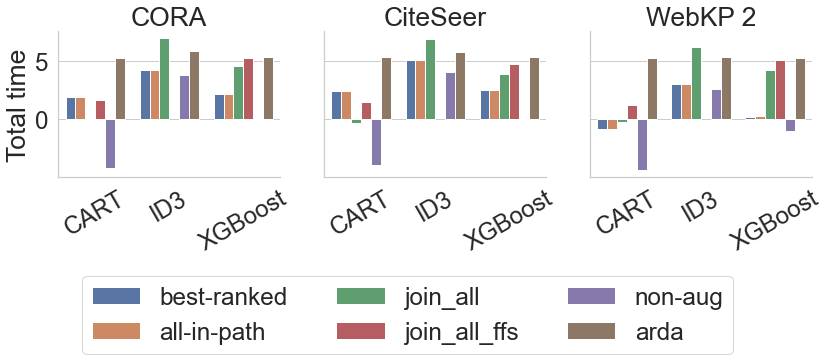

In [31]:
from cmath import log
# display(train_time)

#### TOTAL TIME BIG datasets
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

total_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
total_time_filtered = total_time[total_time['dataset'].isin(big_datasets)]
# total_time_filtered = total_time_filtered[total_time_filtered['approach'] != 'join_all']
total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
total_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=total_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)


g.savefig('plots/total-time-all-big.pdf', dpi=300, bbox_inches="tight")